# Call viral barcodes from 10X Illumina reads
This Python Jupyter notebook process the aligned 10X FASTQ reads to call viral barcodes in reads that align to a barcoded viral gene in droplets that have already been called as cells.

## Parameters
First, set the parameters for the notebook, such as to specify the input files and output plots.
This is done in the next cell, which is tagged as a `parameters` cell to enable [papermill parameterization](https://papermill.readthedocs.io/en/latest/usage-parameterize.html):

In [33]:
# parameters cell; in order for notebook to run this cell must define:
#  - bc_viral_gene: name of barcoded viral gene being parsed
#  - input_cell_barcodes: list of cell barcodes (for called cells) from `STARsolo`
#  - input_aligned_fastq10x_bam: BAM file with `STARsolo` alignments of 10X FASTQ reads
#  - input_aligned_fastq10x_bam_index: index for `input_aligned_fastq10x_bam`
#  - input_viral_genome: Genbank file with viral genes, with `viral_barcode` feature annotations
#  - input_viral_tags: YAML file giving identities of viral tag for each tag variant
#  - output_viral_reads: .fastq.gz of 10X reads that aligned to viral gene with valid cell barcode
#  - output_viral_reads_realigned_sam: SAM file of `output_viral_reads` re-aligned to viral gene
#  - output_viral_reads_realigned_bam: BAM of `output_viral_reads_realigned_sam`
bc_viral_gene = 'fluHA'
input_cell_barcodes = 'results/aligned_fastq10x/wt_virus_pilot/Solo.out/Gene/filtered/barcodes.tsv'
input_aligned_fastq10x_bam = 'results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam'
input_aligned_fastq10x_bam_index = 'results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam.bai'
input_viral_genome = 'data/flu_sequences/flu-CA09.gb'
input_viral_tags = 'data/flu_sequences/flu-CA09_viral_tags.yaml'
output_viral_reads = 'results/viralbc_fastq10x/wt_virus_pilot_fluHA_reads.fastq.gz'
output_viral_reads_realigned_sam = 'results/viralbc_fastq10x/wt_virus_pilot_fluHA_realigned.sam'
output_viral_reads_realigned_bam = 'results/viralbc_fastq10x/wt_virus_pilot_fluHA_realigned.bam'

## Import Python modules
We use [alignparse](https://jbloomlab.github.io/alignparse) to parse alignments, [anndata](https://anndata.readthedocs.io/) to handle the matrix of cells and viral barcode counts, and [plotnine](https://plotnine.readthedocs.io/) for ggplot2-style plotting:

In [31]:
import contextlib
import gzip
import os
import subprocess

import alignparse.minimap2
import alignparse.targets

import anndata

from IPython.display import display, HTML

import numpy

import pandas as pd

from plotnine import *

import pysam

import yaml

Color-blind palette:

In [3]:
cbpalette = ('#999999', '#E69F00', '#56B4E9', '#009E73',
             '#F0E442', '#0072B2', '#D55E00', '#CC79A7')

Set [plotnine theme](https://plotnine.readthedocs.io/en/stable/api.html#themes):

In [4]:
_ = theme_set(theme_classic)

## Get reads that align to barcoded viral genes
Extract from the BAM file of aligned 10X Illumina reads all those reads that meet the following criteria:
  1. They align to the barcoded viral gene of interest
  2. They correspond to a cell barcode that was called as "valid (non-empty droplet)
  
First, get the set of valid cell barcodes:

In [5]:
cell_barcodes = set(pd.read_csv(input_cell_barcodes, sep='\t', header=None)[0])
print(f"Read {len(cell_barcodes)} valid cell barcodes from {input_cell_barcodes}")

Read 3633 valid cell barcodes from results/aligned_fastq10x/wt_virus_pilot/Solo.out/Gene/filtered/barcodes.tsv


Iterate over reads in the BAM file of aligned 10X reads, filtering for (in order):
 1. Reads that align to the viral gene of interest.
 2. Reads that have a cell barcode (`CB` tag in BAM).
 3. Reads that have a UMI (`UB` tag in BAM).
 4. Reads for which the cell barcode is in the list of valid cells.

In [6]:
print(f"Getting reads in {input_aligned_fastq10x_bam} that align to {bc_viral_gene}"
      f" and have valid cell barcodes; writing to {output_viral_reads}...")

os.makedirs(os.path.dirname(output_viral_reads), exist_ok=True)

with contextlib.ExitStack() as stack:
    # callback to delete `output_viral_reads` on error
    # https://docs.python.org/3/library/contextlib.html#replacing-any-use-of-try-finally-and-flag-variables
    @stack.callback
    def delete_output_viral_reads_on_err():
        if os.path.isfile(output_viral_reads):
            os.remove(output_viral_reads)
    
    samfile = stack.enter_context(
                pysam.AlignmentFile(input_aligned_fastq10x_bam,
                                    mode='rb',
                                    index_filename=input_aligned_fastq10x_bam_index
                                    )
                )
    
    fastqfile = stack.enter_context(gzip.open(output_viral_reads, 'wt'))
    
    n = n_cellbc = n_umi = n_valid_cellbc = 0
    for r in samfile.fetch(contig=bc_viral_gene):
        n += 1
        if r.has_tag('CB'):
            n_cellbc += 1
            if r.has_tag('UB'):
                n_umi += 1
                if r.get_tag('CB') in cell_barcodes:
                    n_valid_cellbc += 1
                    qual_str = ''.join(map(lambda x: chr(x + 33), r.query_qualities))
                    assert len(qual_str) == len(r.query_sequence)
                    fastqfile.write(
                        f"@{r.query_name} CB={r.get_tag('CB')} UB={r.get_tag('UB')}\n"
                        f"{r.query_sequence}\n+\n{qual_str}\n"
                        )
    fastqfile.flush()
                    
    stack.pop_all()

stats = {'total': n,
         'has_cell_barcode': n_cellbc,
         'has_UMI': n_umi,
         'valid_cell_barcode': n_valid_cellbc}

print('Stats on reads:')
display(HTML(
    pd.Series(stats)
    .rename('number of reads')
    .to_frame()
    .to_html()
    ))

Getting reads in results/aligned_fastq10x/wt_virus_pilot/Aligned.sortedByCoord.out.bam that align to fluHA and have valid cell barcodes; writing to results/viralbc_fastq10x/wt_virus_pilot_fluHA_reads.fastq.gz...
Stats on reads:


,number of reads
total,14763
has_cell_barcode,14389
has_UMI,14389
valid_cell_barcode,13496


## Re-align the reads and parse viral barcodes / tags
Now we use [minimap2](https://lh3.github.io/minimap2/) to re-align the reads extracted above to the viral gene, and then parse out viral barcodes and tags using [alignparse](https://jbloomlab.github.io/alignparse/).

### Create alignment target
We need to create an alignparse alignment [Targets](https://jbloomlab.github.io/alignparse/alignparse.targets.html#alignparse.targets.Targets) that contains the features of interest (the viral barcode and an viral tags).

To do this, first get a dictionary listing the viral tags:

In [7]:
print(f"Parsing viral tags for {bc_viral_gene} from {input_viral_tags}")
with open(input_viral_tags) as f:
    viral_tags = yaml.safe_load(f)[bc_viral_gene]
viral_tags

Parsing viral tags for fluHA from data/flu_sequences/flu-CA09_viral_tags.yaml


{'tag_1': {'syn': 'T', 'wt': 'C'}, 'tag_2': {'syn': 'C', 'wt': 'T'}}

Now create the `feature_parse_specs` dict that will be used to create the [Targets](https://jbloomlab.github.io/alignparse/alignparse.targets.html#alignparse.targets.Targets).
We require:
 - the viral barcode to be present with no "mutations" (since it is encoded as `N` nucleotides, this means no indels), and to be returned.
 - the read (query) to be clipped by no more than five nucleotides on each end
 - we don't make requirements about the tags, but specify that they should be returned if present

In [8]:
# start by specifying amount of allowed query (read clipping) at each end
feature_parse_specs = {bc_viral_gene: {'query_clip5': 5,
                                       'query_clip3': 5}
                       }

# Add `viral_barcode`. 
# Specify to return sequence.
# No filter, which means no clipping or mutations allowed.
feature_parse_specs[bc_viral_gene]['viral_barcode'] = {'return': 'sequence'}

# Add each viral tag.
# Specify to return sequence (will be empty if tag not present)
# The filter allows clipping or mutations of 1, which means the tag can be
# absent since tags are of length 1.
for tag in viral_tags:
    feature_parse_specs[bc_viral_gene][tag] = {'return': 'sequence',
                                               'filter': {'clip5': 1,
                                                          'clip3': 1,
                                                          'mutation_nt_count': 1,
                                                          'mutation_op_count': 1}
                                               }
    
feature_parse_specs

{'fluHA': {'query_clip5': 5,
  'query_clip3': 5,
  'viral_barcode': {'return': 'sequence'},
  'tag_1': {'return': 'sequence',
   'filter': {'clip5': 1,
    'clip3': 1,
    'mutation_nt_count': 1,
    'mutation_op_count': 1}},
  'tag_2': {'return': 'sequence',
   'filter': {'clip5': 1,
    'clip3': 1,
    'mutation_nt_count': 1,
    'mutation_op_count': 1}}}}

Next create the [Targets](https://jbloomlab.github.io/alignparse/alignparse.targets.html#alignparse.targets.Targets) for just our gene of interest.
We also plot the targets and print the feature parse specs:

Here are the feature-parse specs: fluHA:
  query_clip5: 5
  query_clip3: 5
  viral_barcode:
    return:
    - sequence
    filter:
      clip5: 0
      clip3: 0
      mutation_nt_count: 0
      mutation_op_count: 0
  tag_1:
    return:
    - sequence
    filter:
      clip5: 1
      clip3: 1
      mutation_nt_count: 1
      mutation_op_count: 1
  tag_2:
    return:
    - sequence
    filter:
      clip5: 1
      clip3: 1
      mutation_nt_count: 1
      mutation_op_count: 1

Here is a drawing of the Targets:


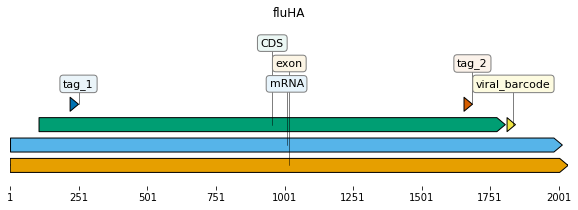

In [9]:
targets = alignparse.targets.Targets(
            seqsfile='data/flu_sequences/flu-CA09.gb',
            feature_parse_specs=feature_parse_specs,
            allow_extra_features=True,  # Genbank may have features not in parse specs
            allow_clipped_muts_seqs=True,  # viral tags may be clipped
            select_target_names=[bc_viral_gene],  # we only want this viral gene in targets
            )

print('Here are the feature-parse specs: ' + targets.feature_parse_specs('yaml'))

print('Here is a drawing of the Targets:')
_ = targets.plot(ax_width=10)

### Create `minimap2` mapper
Create an [alignparse Mapper](https://jbloomlab.github.io/alignparse/alignparse.minimap2.html#alignparse.minimap2.Mapper) to run [minimap2](https://lh3.github.io/minimap2/):

In [10]:
mapper = alignparse.minimap2.Mapper(alignparse.minimap2.OPTIONS_VIRUS_W_DEL)

print(f"Using `minimap2` {mapper.version} with these options:\n" +
      ' '.join(mapper.options))

Using `minimap2` 2.17-r941 with these options:
-xsplice:hq -un -C0 --splice-flank=no -M=1 --for-only --end-seed-pen=2 --end-bonus=2 --secondary=no --cs


### Align and parse the reads
Use [Targets.align_and_parse](https://jbloomlab.github.io/alignparse/alignparse.targets.html#alignparse.targets.Targets.align_and_parse) to...

In [11]:
targets.align(queryfile=output_viral_reads,
              alignmentfile=output_viral_reads_realigned,
              mapper=mapper)


In [36]:
subprocess.check_call(['samtools', 'view', '-S', '-b',
                       output_viral_reads_realigned_sam,
                       '-o', output_viral_reads_realigned_bam])
subprocess.check_call(['samtools', 'index', output_viral_reads_realigned_bam])

with pysam.AlignmentFile(output_viral_reads_realigned_bam, 'rb') as samfile:
    print(samfile.pileup())

CalledProcessError: Command '['samtools', 'index', 'results/viralbc_fastq10x/wt_virus_pilot_fluHA_realigned.bam']' returned non-zero exit status 1.

In [25]:
readstats, aligned, filtered = targets.parse_alignment(
                    samfile=output_viral_reads_realigned)

In [18]:
filtered['fluHA'].groupby('filter_reason').size()

filter_reason
query_clip3                        1140
query_clip5                        1660
viral_barcode clip3                9542
viral_barcode clip5                 572
viral_barcode mutation_nt_count     198
dtype: int64

In [13]:
targets.write_fasta(os.path.join(os.path.dirname(output_viral_reads), 'target.fasta'))

In [22]:
aligned['fluHA'].groupby('tag_2_sequence').size()

tag_2_sequence
    175
dtype: int64

In [23]:
readstats

,category,count
0,aligned fluHA,175
1,filtered fluHA,13112
2,unmapped,209


In [24]:
175 + 13112 + 209

13496